# Analyzing Market Impact From Noise Traders using r/wallstreetbet

In [304]:
import requests
import json
# import getpass
# from io import StringIO
# import glob

import pandas as pd
import datetime as dt
import numpy as np

import matplotlib.pyplot as plt

# 1. Loading r/wsb data

In [45]:
path = "/Users/annieouyang/Downloads/archive/wallstreetbets_submission.json"

# data = []
# for line in open(path, 'r'):
#     data.append(json.loads(line))

data = pd.read_json(path,lines=True)

In [50]:
pd.set_option('display.max_columns', None)
filtered_data = data[['author','created_utc','domain','media_embed','num_comments','score','selftext','subreddit','title']]
filtered_data.head()

,author,created_utc,domain,media_embed,num_comments,score,selftext,subreddit,title
0,[deleted],1334162440,self.wallstreetbets,{},22,13,I know that /r/investing is a great place for ...,wallstreetbets,Earnings season is here. Place your bets.
1,[deleted],1334263051,bloomberg.com,{},0,2,,wallstreetbets,"GOOG - beat estimates, price barely rises."
2,[deleted],1334615377,self.wallstreetbets,{},21,12,"So I missed out on GOOG, which is probably a g...",wallstreetbets,My poorly timed opening position for AAPL earn...
3,[deleted],1334670090,self.wallstreetbets,{},0,1,"I'm normally a long, but I've created a second...",wallstreetbets,Anyone betting on VVUS and their potential app...
4,secondhandsondek,1334844620,imgur.com,{},4,7,,wallstreetbets,"EBAY posts higher 1Q net income and revenue, s..."


In [54]:
filtered_data['timestamp'] = data.created_utc.apply(dt.datetime.fromtimestamp)
filtered_data = filtered_data.set_index('timestamp')

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [56]:
filtered_data.head()

,author,created_utc,domain,media_embed,num_comments,score,selftext,subreddit,title
timestamp,,,,,,,,,
2012-04-11 17:40:40,[deleted],1334162440,self.wallstreetbets,{},22,13,I know that /r/investing is a great place for ...,wallstreetbets,Earnings season is here. Place your bets.
2012-04-12 21:37:31,[deleted],1334263051,bloomberg.com,{},0,2,,wallstreetbets,"GOOG - beat estimates, price barely rises."
2012-04-16 23:29:37,[deleted],1334615377,self.wallstreetbets,{},21,12,"So I missed out on GOOG, which is probably a g...",wallstreetbets,My poorly timed opening position for AAPL earn...
2012-04-17 14:41:30,[deleted],1334670090,self.wallstreetbets,{},0,1,"I'm normally a long, but I've created a second...",wallstreetbets,Anyone betting on VVUS and their potential app...
2012-04-19 15:10:20,secondhandsondek,1334844620,imgur.com,{},4,7,,wallstreetbets,"EBAY posts higher 1Q net income and revenue, s..."


## 2. Filter by those with Ticker and Company name

In [42]:
nyse = pd.read_csv('/Users/annieouyang/Downloads/companylist (1).csv')
nasdaq = pd.read_csv('/Users/annieouyang/Downloads/companylist (3).csv')

In [192]:
tickers = (nyse.Symbol.append(nasdaq.Symbol))

In [242]:
nyse.Name.apply(lambda x:x.replace('The ',''))

0             3D Systems Corporation
1                         3M Company
2                    500.com Limited
3                            8x8 Inc
4              A.H. Belo Corporation
                    ...             
3169    Zimmer Biomet Holdings, Inc.
3170                     Zoetis Inc.
3171       ZTO Express (Cayman) Inc.
3172                     Zuora, Inc.
3173                  Zymeworks Inc.
Name: Name, Length: 3174, dtype: object

In [233]:
# get the first word of the company's full name
nyse_companies = nyse.Name.str.extract('(?:^|(?:[.!?]\s))(\w+)').drop_duplicates()
nasdaq_companies = nasdaq.Name.str.extract('(?:^|(?:[.!?]\s))(\w+)').drop_duplicates()

companies = nyse_companies.append(nasdaq_companies)[0]

## 3. NLP

In [46]:
import nltk
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords 

import itertools
from collections import Counter
from collections import OrderedDict
import operator

## 3.1 Data cleaning

In [259]:
title = filtered_data.title.fillna('')
text = filtered_data.selftext.fillna('')

#lower case
# title = title.str.lower().fillna('')
# text = text.str.lower().fillna('')

#remove punctuation. Will have to ignore punctuation
tokenizer = nltk.RegexpTokenizer(r"\w+")
title = title.apply(tokenizer.tokenize)
text = text.apply(tokenizer.tokenize)

#removing stop words
stop_words = set(stopwords.words('english'))
stop_words.add('com')
stop_words.add('http')
stop_words.add('www')
stop_words.add('amp')
stop_words.update([str(x) for x in np.arange(10)])
#Blacklisted words (WSB slang from WSB Tickerbot)
stop_words.update([
      "YOLO", "TOS", "CEO", "CFO", "CTO", "DD", "BTFD", "WSB", "OK", "RH",
      "KYS", "FD", "TYS", "US", "USA", "IT", "ATH", "RIP", "BMW", "GDP",
      "OTM", "ATM", "ITM", "IMO", "LOL", "DOJ", "BE", "PR", "PC", "ICE",
      "TYS", "ISIS", "PRAY", "PT", "FBI", "SEC", "GOD", "NOT", "POS", "COD",
      "AYYMD", "FOMO", "TL;DR", "EDIT", "STILL", "LGMA", "WTF", "RAW", "PM",
      "LMAO", "LMFAO", "ROFL", "EZ", "RED", "BEZOS", "TICK", "IS", "DOW"
      "AM", "PM", "LPT", "GOAT", "FL", "CA", "IL", "PDFUA", "MACD", "HQ",
      "OP", "DJIA", "PS", "AH", "TL", "DR", "JAN", "FEB", "JUL", "AUG",
      "SEP", "SEPT", "OCT", "NOV", "DEC", "FDA", "IV", "ER", "IPO", "RISE"
      "IPA", "URL", "MILF", "BUT", "SSN", "FIFA", "USD", "CPU", "AT",
      "GG", "ELON"
   ])

title = title.apply(lambda x: [i for i in x if not i in stop_words])
text = text.apply(lambda x: [i for i in x if not i in stop_words])

In [260]:
def most_common_words(series):
    lst_words = list(itertools.chain.from_iterable(series))
    dict_words = OrderedDict(sorted(Counter(lst_words).items(), key=operator.itemgetter(1), reverse=True))
    return dict_words

In [261]:
list(filtered_data.selftext[:100])

["I know that /r/investing is a great place for congregating with fellow market gamblers - but it's not *exactly* the right place to be.  So rather than flooding it with gambling posts and epic win/loss screen shots I figured I'd make another sub for this specifically for speculating and such.  We'll see if it works.  Subscribe if you're interested.\n\n\nAnyways, upcomming earnings (feel free to add):\n\n* AAPL - 4/24\n\n* AMZN - 4/25 (unconfirmed)\n\n* GOOG - 4/12 (TOMORROW! - after market closes)\n\n* GRPN - 5/14 (far enough away that IV isn't built in yet)\n\n* LNKD - 5/4 (unconfirmed)\n\n* NFLX - 4/23\n\n* PCLN - 5/8 (unconfirmed)\n\n* ANF - 5/16\n\n* GMCR - 5/2 (unconfirmed)\n\n* LVS - 5/4 (unconfirmed)\n\nThere's a list of the ones I'm following, based on their previously significant moves post-earnings.  What are yours? And if you're betting, what's your move?  I haven't decided my own yet, but I'll let you know when I do.  Google is tempting, but there's so much volatility buil

## 3.2 Most Common Tickers

To minimize noise, 4 types of common tickers: tickers from 

Assumption: 

1. All tickers in lower case are ignored
2. Company names are taken by the first word of their full name listed on NYSE or Nasdaq

(Can be corrected by WSB Tickerbot later) 

In [268]:
top_text = most_common_words(text)
top_title = most_common_words(title)
english_words = set(nltk.corpus.words.words())

In [323]:
top_text

OrderedDict([('I', 243789),
             ('removed', 84930),
             ('https', 65114),
             ('The', 42418),
             ('like', 36134),
             ('market', 36097),
             ('stock', 32597),
             ('going', 29285),
             ('money', 28583),
             ('get', 27383),
             ('earnings', 27010),
             ('r', 25204),
             ('time', 25177),
             ('would', 24217),
             ('buy', 23783),
             ('deleted', 22842),
             ('go', 22646),
             ('wallstreetbets', 22585),
             ('know', 22550),
             ('calls', 22002),
             ('This', 21899),
             ('one', 21275),
             ('think', 21127),
             ('gt', 20755),
             ('company', 20488),
             ('week', 20236),
             ('day', 19977),
             ('people', 19884),
             ('price', 19451),
             ('It', 19421),
             ('make', 19149),
             ('year', 18778),
             ('new', 

$\big{(} 1 - \sum_{k=0}^8 e^{-7}\frac{7^k}{k!} \big{)}\big{(} 1 - \sum_{k=0}^8 e^{-5}\frac{5^k}{k!} \big{)} \approx 1.84\%$

### Major error: roughly 1/3 of tickers are lowercase, will be filtered out

In [269]:
def top_ticker(title_text,ticker_company):
    if title_text == 'title':
        dic = top_title.copy()            
    elif title_text == 'text':
        dic = top_text.copy()
        
    unwanted_tickers = set(dic.keys()) - set(ticker_company)
    for unwanted_key in unwanted_tickers: del dic[unwanted_key]  
        
    return dic

In [270]:
top_text_ticker = top_ticker('text',tickers)
top_title_ticker = top_ticker('title',tickers)
top_text_companies = top_ticker('text',companies)
top_title_companies = top_ticker('title',companies)

In [271]:
top_title_ticker

OrderedDict([('TSLA', 7579),
             ('AMD', 6880),
             ('A', 5959),
             ('MU', 4331),
             ('AAPL', 2299),
             ('SNAP', 2248),
             ('MSFT', 2218),
             ('AMZN', 2132),
             ('NVDA', 2094),
             ('SPCE', 1900),
             ('FB', 1769),
             ('U', 1491),
             ('F', 1264),
             ('DIS', 1219),
             ('NFLX', 1191),
             ('SQ', 1071),
             ('BABA', 1065),
             ('GE', 1025),
             ('BYND', 1008),
             ('T', 992),
             ('ON', 956),
             ('RAD', 948),
             ('ATVI', 917),
             ('ALL', 832),
             ('JD', 789),
             ('IQ', 777),
             ('BA', 759),
             ('E', 733),
             ('V', 681),
             ('TWTR', 654),
             ('SHOP', 654),
             ('PSA', 646),
             ('FOR', 628),
             ('BAC', 617),
             ('NIO', 616),
             ('D', 611),
             ('Y',

In [272]:
top_text_ticker

OrderedDict([('A', 8955),
             ('FOR', 8140),
             ('AMD', 4802),
             ('TSLA', 4600),
             ('U', 3899),
             ('MSFT', 2745),
             ('MU', 2537),
             ('AAPL', 2504),
             ('E', 2181),
             ('AMZN', 2061),
             ('FB', 1885),
             ('T', 1875),
             ('C', 1579),
             ('AM', 1578),
             ('NVDA', 1440),
             ('B', 1437),
             ('SPCE', 1421),
             ('ET', 1363),
             ('D', 1355),
             ('LIVE', 1225),
             ('DIS', 1178),
             ('SNAP', 1177),
             ('F', 1136),
             ('NFLX', 1071),
             ('BA', 1008),
             ('GE', 1006),
             ('Y', 978),
             ('M', 956),
             ('X', 915),
             ('R', 902),
             ('V', 896),
             ('BABA', 887),
             ('ALL', 844),
             ('ATVI', 816),
             ('BYND', 788),
             ('SQ', 787),
             ('QQQ', 78

In [273]:
top_text_companies

OrderedDict([('I', 243789),
             ('The', 42418),
             ('one', 21275),
             ('So', 15885),
             ('S', 13104),
             ('A', 8955),
             ('China', 8330),
             ('My', 7195),
             ('P', 6842),
             ('Just', 5390),
             ('500', 5251),
             ('Tesla', 4419),
             ('U', 3899),
             ('Apple', 3396),
             ('On', 3336),
             ('support', 3213),
             ('Amazon', 2831),
             ('At', 2569),
             ('New', 2421),
             ('e', 2208),
             ('E', 2181),
             ('Stock', 2050),
             ('Good', 2008),
             ('American', 1954),
             ('FB', 1885),
             ('T', 1875),
             ('Q2', 1872),
             ('First', 1870),
             ('Best', 1854),
             ('One', 1849),
             ('People', 1831),
             ('America', 1830),
             ('ETF', 1792),
             ('C', 1579),
             ('Facebook', 1465),
 

In [274]:
top_title_companies

OrderedDict([('I', 70055),
             ('The', 14093),
             ('one', 8257),
             ('A', 5959),
             ('My', 5800),
             ('Tesla', 4868),
             ('Just', 3643),
             ('S', 3431),
             ('China', 3064),
             ('So', 3017),
             ('New', 3009),
             ('Stock', 2838),
             ('First', 2273),
             ('500', 1940),
             ('P', 1887),
             ('Apple', 1843),
             ('FB', 1769),
             ('Amazon', 1643),
             ('One', 1568),
             ('Daily', 1564),
             ('Oil', 1529),
             ('U', 1491),
             ('Good', 1453),
             ('Big', 1388),
             ('Best', 1374),
             ('F', 1264),
             ('Gold', 1190),
             ('On', 1158),
             ('ETF', 1129),
             ('T', 992),
             ('Facebook', 971),
             ('ON', 956),
             ('News', 934),
             ('Netflix', 841),
             ('Twitter', 838),
          

### Manually sort through top companies, tickers (5 from each category) 

2. TSLA
3. AMD
4. A
5. MU
6. MSFT
7. Tesla
8. Apple
9. Amazon
10. Gold
11. Facebook
12. United

In [205]:
list(filtered_data.selftext)

["I know that /r/investing is a great place for congregating with fellow market gamblers - but it's not *exactly* the right place to be.  So rather than flooding it with gambling posts and epic win/loss screen shots I figured I'd make another sub for this specifically for speculating and such.  We'll see if it works.  Subscribe if you're interested.\n\n\nAnyways, upcomming earnings (feel free to add):\n\n* AAPL - 4/24\n\n* AMZN - 4/25 (unconfirmed)\n\n* GOOG - 4/12 (TOMORROW! - after market closes)\n\n* GRPN - 5/14 (far enough away that IV isn't built in yet)\n\n* LNKD - 5/4 (unconfirmed)\n\n* NFLX - 4/23\n\n* PCLN - 5/8 (unconfirmed)\n\n* ANF - 5/16\n\n* GMCR - 5/2 (unconfirmed)\n\n* LVS - 5/4 (unconfirmed)\n\nThere's a list of the ones I'm following, based on their previously significant moves post-earnings.  What are yours? And if you're betting, what's your move?  I haven't decided my own yet, but I'll let you know when I do.  Google is tempting, but there's so much volatility buil

# 4. Number of mentions per ticker overtime

In [329]:
#Titl contains AMD
AMD = filtered_data[filtered_data.title.apply(lambda x: 'AMD' in x)]
MU = filtered_data[filtered_data.title.apply(lambda x: 'MU' in x)]
TSLA = filtered_data[filtered_data.title.apply(lambda x: 'TSLA' in x)]

In [330]:
AMD

,author,created_utc,domain,media_embed,num_comments,score,selftext,subreddit,title
timestamp,,,,,,,,,
2012-07-21 01:25:41,which_governs_least,1342830341,self.wallstreetbets,{},0,0,AMD is at $4.22 for the weekend... what do you...,wallstreetbets,[AMD] To buy or not to buy...
2012-09-18 18:34:54,gaog,1347989694,self.wallstreetbets,{},13,12,Let's guess the bottom for 2012!,wallstreetbets,Falling knife AMD
2012-10-21 14:47:04,Lyrus,1350827224,self.wallstreetbets,{},5,5,Both companies have reported weak earnings rec...,wallstreetbets,MSFT and AMD?
2013-05-28 20:40:09,Mikeavelli,1369770009,i.imgur.com,{},18,16,,wallstreetbets,"As pointed out on /r/gaming, is AMD a good bet..."
2013-08-27 01:26:07,Youareme2,1377563167,self.wallstreetbets,{},2,0,AMD will be heavily integrated within the new ...,wallstreetbets,AMD - Buy call options based on release of XON...
...,...,...,...,...,...,...,...,...,...
2020-08-14 19:46:06,gaklein2007,1597430766,self.wallstreetbets,NaN,2,1,[removed],wallstreetbets,AMD C @ 85 worth holding?
2020-08-14 19:48:42,gaklein2007,1597430922,self.wallstreetbets,NaN,2,1,[removed],wallstreetbets,AMD 21/08 Call question
2020-08-14 19:50:13,gaklein2007,1597431013,self.wallstreetbets,NaN,2,1,[removed],wallstreetbets,AMD 21/08 85C


In [326]:
sum(AMD.author)

6964

In [320]:
AMD['hourly']=AMD.index.round('H')
# AMD = AMD.groupby('hourly').count()
AMD.to_csv('AMD.csv')

MU['hourly']=MU.index.round('H')
# MU = MU.groupby('hourly').count()
MU.to_csv('MU.csv')

TSLA['hourly']=TSLA.index.round('H')
# TSLA = TSLA.groupby('hourly').count()
TSLA.to_csv('TSLA.csv')

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a c

5017

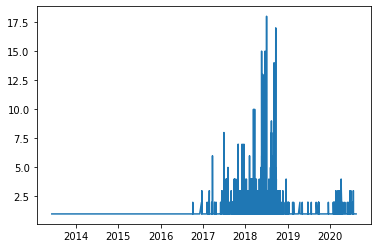

In [327]:
plt.plot(MU.author)
sum(MU.author)